<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

<center> <img src=https://i.imgur.com/0TSSaqL.png width="550"> </center>
<h6>
<center><b>Módulo 5 - Unidad 4</b></center>
<center><b>Deep Learning</b></center>
<center><b>Natual Language Processing</b></center>
<center><b>Caso Práctico - Adriana Vargas</b></center>
</h6>

# Caso de Análisis - Clasificación de Textos

El propietario de un restaurante os ha encargado una herramienta que le envíe emails automáticamente cuando su restaurante reciba una reseña negativa. Vuestro objetivo es entrenar un modelo que a partir del texto de una reseña sepa detectar como de positiva o negativa es esta.

Vamos a trabajar con el dataset restaurant_ratings.csv, que tiene 4 columnas:

* Name: El nombre del restaurante.
* Rating: El número de estrellas dadas por el usuario.
* Review: La reseña escrita por el usuario.
* Bad: 0 si la review se considera buena (si su rating es igual o mayor que 2.5), 1 si se considera mala (si su rating es inferior a 2.5).

Tenéis que entrenar un modelo de clasificación usando la columna "bad" como target. Por favor, eliminad las columnas "name" y "rating". La primera no aporta nada útil. Y la segunda se supone que no la sabemos cuando recibimos una reseña, ya que en el escenario planteado se supone que solo recibimos el texto de esta.

# 0. Preparación del ambiente de trabajo

Cargamos los datos e importamos todas las bibliotecas que vamos a necesitar.

In [20]:
import numpy as np
import pandas as pd

# Text processing libraries
import re
import string
from IPython.display import HTML
import nltk
nltk.download('stopwords') # first time
from nltk.corpus import stopwords

# sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,balanced_accuracy_score,roc_curve, auc,classification_report

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Lemmatizing
nltk.download('wordnet') # first time
#nltk.download('omw-1.4') # first time
from nltk.stem import WordNetLemmatizer

# wordcloud
from wordcloud import WordCloud

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Lime for explain the results
!pip install lime # first time
from lime import lime_text
from lime.lime_text import LimeTextExplainer

from sklearn.pipeline import make_pipeline

# Sentiment analysis with Vader
!pip install vaderSentiment # first time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Definimos las funciones que vamos a utilizar a lo largo del análisis:

In [21]:
# Make text lowercase, remove text in square brackets,
# remove links, remove punctuation
# and remove words containing numbers.

def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text) # remove text in square brackets
  text = re.sub('https?://\S+|www\.\S+', '', text) # remove urls, https
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', '', text) # get rid of digits, ie numbers
  return text.strip()


In [22]:
# Pre-processing text: Tokenization, lemmatizing,
# remove stop words and punctuation.

def text_preprocessing(text, stop_words):

  # 1. Data cleaning on the text variable
  nopunc = clean_text(text)

  # 2. Tokenize the cleaned_text
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  nopunc = tokenizer.tokenize(nopunc)

  # 3. Remove punctuations and stopwords
  remove_stopwords = [w for w in nopunc if w not in stop_words]

  # 4. Lematize the cleaned_text
  wn = nltk.WordNetLemmatizer()
  lemmas = [wn.lemmatize(word) for word in remove_stopwords]

  # 5. Join the information
  combined_text = ' '.join(lemmas)
  return combined_text


In [23]:
# Show in parallel both words clouds, for positive and negative reviews

def show_clouds(positive_reviews, negative_reviews):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

  wordcloud1 = WordCloud(background_color='white',
    width=600,
    height=400).generate(" ".join(positive_reviews))

  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title('Positive Reviews',fontsize=40)

  wordcloud2 = WordCloud(background_color='white',
    width=600,
    height=400).generate(" ".join(negative_reviews))
  ax2.imshow(wordcloud2)
  ax2.axis('off')
  ax2.set_title('Negative Reviews',fontsize=40);


In [24]:
def show_metrics(y_test, y_pred_result):
  print("Accuracy:", "{:10.4f}".format(accuracy_score(y_test, y_pred_result, normalize=True)))
  print("Precision:", "{:10.4f}".format(precision_score(y_test, y_pred_result)))
  print("Recall:", "{:10.4f}".format(recall_score(y_test, y_pred_result)))
  print("F1:", "{:10.4f}".format(f1_score(y_test,y_pred_result)))
  print("\n", classification_report(y_test, y_pred_result))

In [25]:
# Prediction explanation with Lime

def explain_classification(vect, classifier, text):
  c = make_pipeline(vect, classifier)

  print("Original text:\n" + text + "\n")
  print("Probability estimates [positive/negative]:\n"
        + str(c.predict_proba([text])) + "\n") # Prediction is 1, i.e., bad

  class_names = ["positive", "negative"]
  explainer = LimeTextExplainer(class_names=class_names)
  exp = explainer.explain_instance(text_instance=text,
    classifier_fn=c.predict_proba,
    num_features=10)

  print("Probabilities:\n" + str(exp.as_list()) + "\n")
  display(HTML(data=exp.as_html()))

  exp.as_pyplot_figure()

# 1. Exploración de los datos

Cargamos los datos que vamos a usar.

In [26]:
filename = 'restaurant_ratings.csv'
data = pd.read_csv(filename)

Vamos a explorar cantidad de registros, columnas, tipos y valores nulos.

In [27]:
data.shape

(121814, 5)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121814 entries, 0 to 121813
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  121814 non-null  int64  
 1   name        121814 non-null  object 
 2   rating      121814 non-null  float64
 3   review      121492 non-null  object 
 4   bad         121814 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.6+ MB


In [29]:
data.head()

Unnamed: 0               name  rating  \
0      228122       Crawl Street     3.0   
1      400236  The Spicy Kitchen     1.0   
2       35438        Kabab Treat     5.0   
3      262748          Pooja Veg     4.0   
4     1008738     Ammi's Biryani     3.5   

                                              review  bad  
0  Ambience  35  Too noisy\nFood  3\nService  4\n...  0.0  
1  If I could  I would rate it in negativeWorst s...  1.0  
2                                    Hemanth reddyK   0.0  
3  Try out the filter coffee masala dosa idly and...  0.0  
4  Decent Mutton Biryani Consistent I have tried ...  0.0

Vamos a eliminar las columnas "name" y "rating". La primera no aporta al análisis, y la segunda se supone que no la sabemos en el escenario normal en el que solo recibimos las reseñas.

In [30]:
train = data.loc[:,['review','bad']]
train.head()

review  bad
0  Ambience  35  Too noisy\nFood  3\nService  4\n...  0.0
1  If I could  I would rate it in negativeWorst s...  1.0
2                                    Hemanth reddyK   0.0
3  Try out the filter coffee masala dosa idly and...  0.0
4  Decent Mutton Biryani Consistent I have tried ...  0.0

Ahora vamos a revisar los valores nulos.

In [31]:
train.isnull().sum()

review    322
bad         0
dtype: int64

Tenemos 322 registros de review sin texto, los eliminamos:

In [32]:
train = train.dropna().reset_index(drop=True)
train.isnull().sum()

review    0
bad       0
dtype: int64

In [33]:
train.shape

(121492, 2)

Vamos a explorar la proporción de reseñas clasificadas como buenas y malas.

In [34]:
train['bad'].value_counts()

0.0    100463
1.0     21029
Name: bad, dtype: int64

Tenemos un 82,69% de reseñas positivas, y un 17,31% de reseñas negativas.

In [35]:
train["bad"].value_counts(normalize = True)

0.0    0.82691
1.0    0.17309
Name: bad, dtype: float64

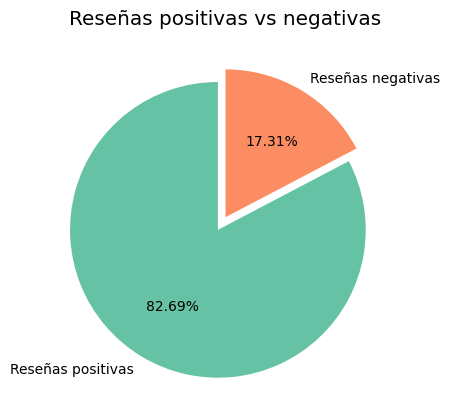

In [36]:
# Define data
vf = train["bad"].value_counts(normalize = True)
data = [ vf[0], vf[1]]
explode = (0.1, 0)

# Create pie chart
labels = ["Reseñas positivas","Reseñas negativas"]
plt.pie(data, labels = labels, autopct='%.2f%%', startangle=90,
        explode=explode, colors=sns.color_palette('Set2'))
plt.title("Reseñas positivas vs negativas")
plt.show()

Finalmente vamos a revisar algunos textos de reseñas positivas y negativas.

In [37]:
train.review[train.bad == 0]

0         Ambience  35  Too noisy\nFood  3\nService  4\n...
2                                           Hemanth reddyK 
3         Try out the filter coffee masala dosa idly and...
4         Decent Mutton Biryani Consistent I have tried ...
5         Great ambience good food and best service by t...
                                ...                        
121485                                           very tasty
121486    Amazing food really great the quantity was a b...
121488    Pasta Street has come up with yet another outl...
121489    Want to give it 35\nNice and quiet ambience\nF...
121491         poha is nice but upma is quite rough and dry
Name: review, Length: 100463, dtype: object

In [38]:
train.review[train.bad == 1]

1         If I could  I would rate it in negativeWorst s...
20               no chicken pieces was therenot good at all
32        DOUBLE THUMBS DOWN bad experience today at 170...
46        Worst decision ever They are just robbing peop...
47         quantity is not okay insufficient food delivered
                                ...                        
121480    The Pizza they delivered was cold and was not ...
121482                                      food is not gud
121484    It used to be a nice place to eat but in my la...
121487    The prices are high for the Quantity and quali...
121490    will never order from this restaurant I should...
Name: review, Length: 21029, dtype: object

# 2. Preprocesado y limpieza de los textos EDA

Ahora vamos a realizar una primera ronda de limpieza, convirtiendo el texto en lowercase, y removiendo links, square brackets, puntuación y caracteres numéricos.

Esto a través de la función clean_text definida en la Sección 0 - Preparación del ambiente de trabajo.

In [39]:
# Apply the clean_text function
train['clean_review_1'] = train['review'].apply(lambda x: clean_text(x))

train.head(10)

review  bad  \
0  Ambience  35  Too noisy\nFood  3\nService  4\n...  0.0   
1  If I could  I would rate it in negativeWorst s...  1.0   
2                                    Hemanth reddyK   0.0   
3  Try out the filter coffee masala dosa idly and...  0.0   
4  Decent Mutton Biryani Consistent I have tried ...  0.0   
5  Great ambience good food and best service by t...  0.0   
6  Ambiance  The live music and the quirky decor ...  0.0   
7  Food tastes really good Very Different Chinese...  0.0   
8  Extremely happy about my orderthe food was als...  0.0   
9  didnt get half my order  zomato credited me th...  0.0   

                                      clean_review_1  
0  ambience    too noisy food   service    saw th...  
1  if i could  i would rate it in negativeworst s...  
2                                     hemanth reddyk  
3  try out the filter coffee masala dosa idly and...  
4  decent mutton biryani consistent i have tried ...  
5  great ambience good food and best service by t...  
6  ambiance  the live music and the quirky decor ...  
7  food tastes really good very different chinese...  
8  extremely happy about my orderthe food was als...  
9  didnt get half my order  zomato credited me th...

Generamos unas nubes de palabras, para comparar las palabras que aparecen en los dos casos tenemos que separar nuestros datos en dos conjuntos diferentes.

In [40]:
positive_reviews = train[train['bad']==0]['clean_review_1']
negative_reviews = train[train['bad']==1]['clean_review_1']

Visualizamos ambas nubes de palabras:

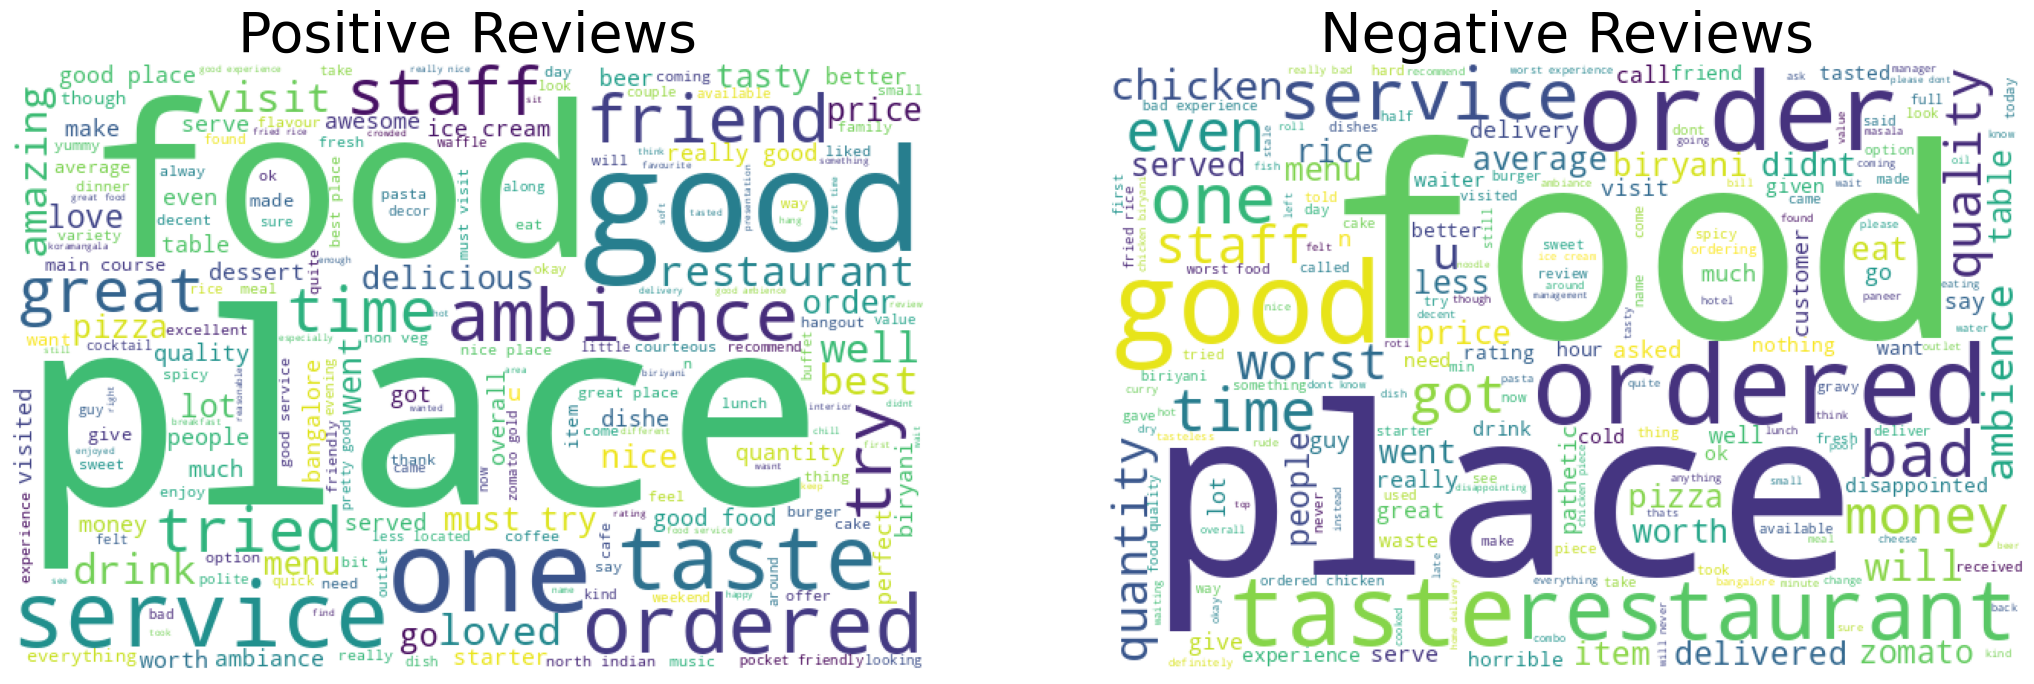

In [41]:
show_clouds(positive_reviews, negative_reviews)

Las palabras mas comunes siguen siendo genéricas, pero en las menos frecuentes empezamos a encontrar rasgos positivos vs negativos.

Para mejorar las nubes de palabras vamos a seguir "normalizando" nuestros datos, por lo que vamos a realizar lo siguiente:

* Obtenemos los tokens de las palabras
* Lematizamos
* Eliminamos los signos de puntuación y las stopwords actualizadas

In [42]:
# Setup the stop words
stop_words = set(stopwords.words('english'))
stop_words.update(["one", "didnt"])

# Process the text, second round of cleaning
train['clean_review_2'] = train['clean_review_1'].apply(lambda x : text_preprocessing(x, stop_words))

train.head(10)

review  bad  \
0  Ambience  35  Too noisy\nFood  3\nService  4\n...  0.0   
1  If I could  I would rate it in negativeWorst s...  1.0   
2                                    Hemanth reddyK   0.0   
3  Try out the filter coffee masala dosa idly and...  0.0   
4  Decent Mutton Biryani Consistent I have tried ...  0.0   
5  Great ambience good food and best service by t...  0.0   
6  Ambiance  The live music and the quirky decor ...  0.0   
7  Food tastes really good Very Different Chinese...  0.0   
8  Extremely happy about my orderthe food was als...  0.0   
9  didnt get half my order  zomato credited me th...  0.0   

                                      clean_review_1  \
0  ambience    too noisy food   service    saw th...   
1  if i could  i would rate it in negativeworst s...   
2                                     hemanth reddyk   
3  try out the filter coffee masala dosa idly and...   
4  decent mutton biryani consistent i have tried ...   
5  great ambience good food and best service by t...   
6  ambiance  the live music and the quirky decor ...   
7  food tastes really good very different chinese...   
8  extremely happy about my orderthe food was als...   
9  didnt get half my order  zomato credited me th...   

                                      clean_review_2  
0  ambience noisy food service saw zomato review ...  
1  could would rate negativeworst shawarma ever d...  
2                                     hemanth reddyk  
3  try filter coffee masala dosa idly everything ...  
4  decent mutton biryani consistent tried time ra...  
5  great ambience good food best service staff me...  
6  ambiance live music quirky decor set right moo...  
7  food taste really good different chinese menu ...  
8      extremely happy orderthe food also good tasty  
9      get half order zomato credited balance amount

Actualizamos las nubes de palabras:

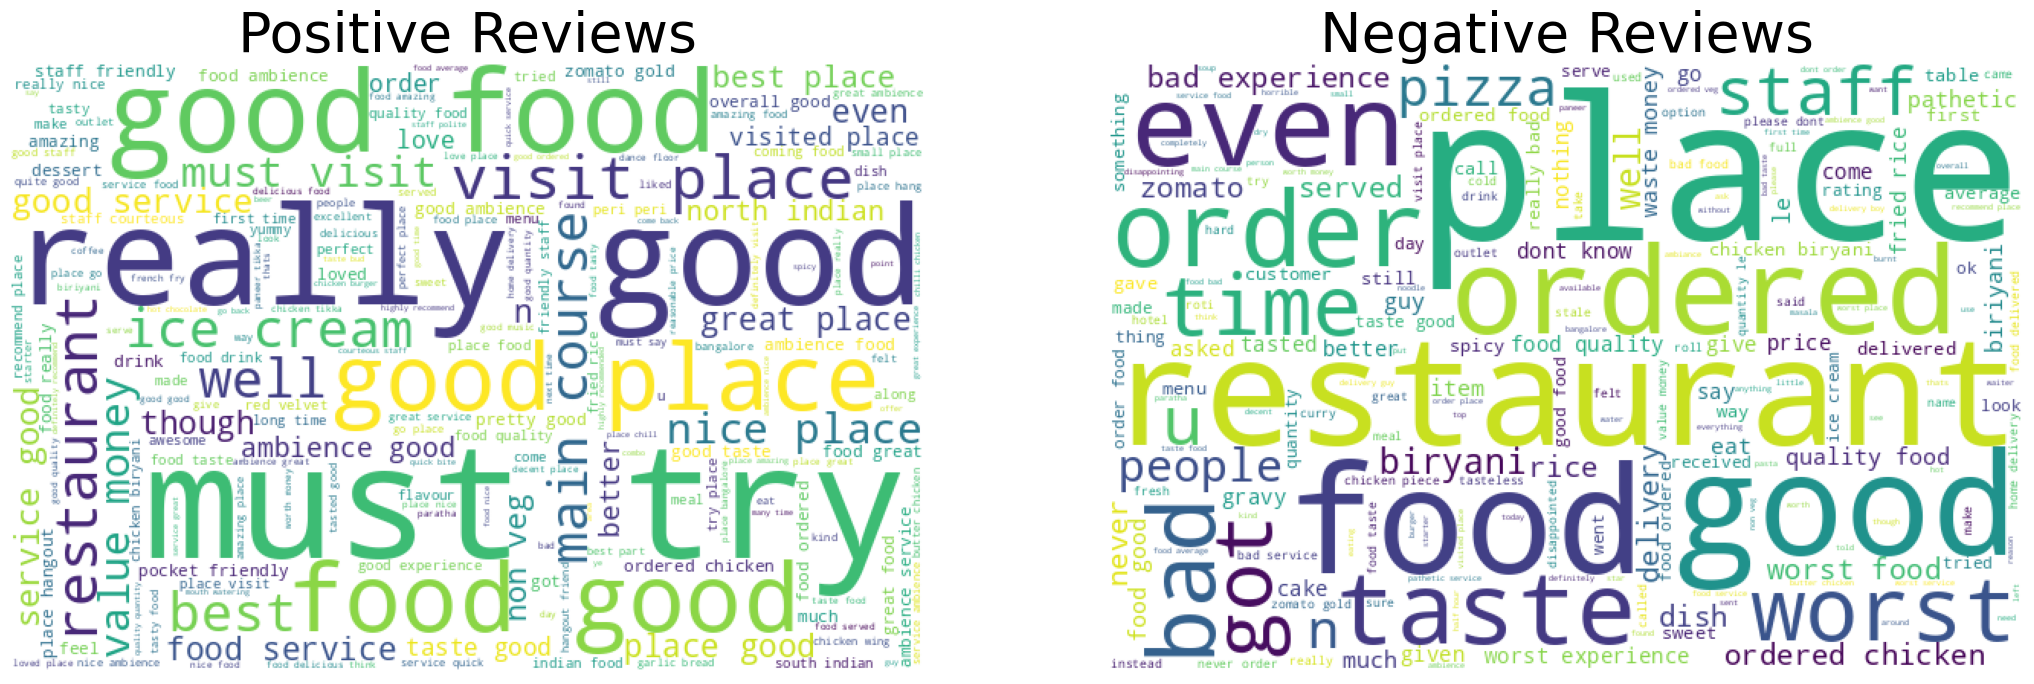

In [43]:
positive_reviews = train[train['bad']==0]['clean_review_2']
negative_reviews = train[train['bad']==1]['clean_review_2']

show_clouds(positive_reviews, negative_reviews)

Las nubes ahora representan un poco mejor las palabras sobresalientes en ambos casos, tanto en reviews positivos como negativos.

Ahora vamos a revisar algunos textos antes y después del proceso de limpieza:

In [45]:
train.head(20)

review  bad  \
0   Ambience  35  Too noisy\nFood  3\nService  4\n...  0.0   
1   If I could  I would rate it in negativeWorst s...  1.0   
2                                     Hemanth reddyK   0.0   
3   Try out the filter coffee masala dosa idly and...  0.0   
4   Decent Mutton Biryani Consistent I have tried ...  0.0   
5   Great ambience good food and best service by t...  0.0   
6   Ambiance  The live music and the quirky decor ...  0.0   
7   Food tastes really good Very Different Chinese...  0.0   
8   Extremely happy about my orderthe food was als...  0.0   
9   didnt get half my order  zomato credited me th...  0.0   
10  Ive never been to this place But I have ordere...  0.0   
11  Update  They now accept cards\n\nFood review \...  0.0   
12  Soya chaap brings back the memories of old Nor...  0.0   
13  Have bookmarked this place since it was coming...  0.0   
14  After fun games at Play Arena when it was time...  0.0   
15  Came across this place near my home\nOverall f...  0.0   
16  Prost brew pub in kormangala is a very famous ...  0.0   
17  Visited for the first time on a friends birthd...  0.0   
18  Best place for vegetarians Good locality Quick...  0.0   
19  House of commons is the best place to be with ...  0.0   

                                       clean_review_1  \
0   ambience    too noisy food   service    saw th...   
1   if i could  i would rate it in negativeworst s...   
2                                      hemanth reddyk   
3   try out the filter coffee masala dosa idly and...   
4   decent mutton biryani consistent i have tried ...   
5   great ambience good food and best service by t...   
6   ambiance  the live music and the quirky decor ...   
7   food tastes really good very different chinese...   
8   extremely happy about my orderthe food was als...   
9   didnt get half my order  zomato credited me th...   
10  ive never been to this place but i have ordere...   
11  update  they now accept cards  food review  it...   
12  soya chaap brings back the memories of old nor...   
13  have bookmarked this place since it was coming...   
14  after fun games at play arena when it was time...   
15  came across this place near my home overall fo...   
16  prost brew pub in kormangala is a very famous ...   
17  visited for the first time on a friends birthd...   
18  best place for vegetarians good locality quick...   
19  house of commons is the best place to be with ...   

                                       clean_review_2  
0   ambience noisy food service saw zomato review ...  
1   could would rate negativeworst shawarma ever d...  
2                                      hemanth reddyk  
3   try filter coffee masala dosa idly everything ...  
4   decent mutton biryani consistent tried time ra...  
5   great ambience good food best service staff me...  
6   ambiance live music quirky decor set right moo...  
7   food taste really good different chinese menu ...  
8       extremely happy orderthe food also good tasty  
9       get half order zomato credited balance amount  
10  ive never place ordered food two time great pl...  
11  update accept card food review good takeaway i...  
12  soya chaap brings back memory old north india ...  
13  bookmarked place since coming chance visit hal...  
14  fun game play arena time lunch skeptical visit...  
15  came across place near home overall food quali...  
16  prost brew pub kormangala famous cool place ha...  
17  visited first time friend birthday ambience de...  
18  best place vegetarian good locality quick good...  
19  house common best place friend great hangout c...

In [46]:
# Original review
print(train.iloc[0,0])

Ambience  35  Too noisy
Food  3
Service  4

Saw the zomato review and thought of visiting Crawl street Place was super noisy and food was okayish Tried Chicken satay and Fish in mustard sauce


In [47]:
# First round cleaning
print(train.iloc[0,2])

ambience    too noisy food   service    saw the zomato review and thought of visiting crawl street place was super noisy and food was okayish tried chicken satay and fish in mustard sauce


In [48]:
# Second round cleaning
print(train.iloc[0,3])

ambience noisy food service saw zomato review thought visiting crawl street place super noisy food okayish tried chicken satay fish mustard sauce


In [49]:
# Original review
print(train.iloc[46,0])

Worst decision ever They are just robbing people The quantity is so less And not even worth what
u pay for Food bowl is not even the length of spoon


In [50]:
# First round cleaning
print(train.iloc[46,2])

worst decision ever they are just robbing people the quantity is so less and not even worth what u pay for food bowl is not even the length of spoon


In [51]:
# Second round cleaning
print(train.iloc[46,3])

worst decision ever robbing people quantity le even worth u pay food bowl even length spoon


In [52]:
# Original review
print(train.iloc[5,0])

Great ambience good food and best service by the staff members

Special mention for Desmond sir He is by far the best restaurant staff I have ever met Very courteous and cheerful person who really believes in great customer service

It was my first visit and we ordered
Jalapeno cheese bites recommended
Bacon wrapped prawns good
Murg malai tikka was ok but nothing great
Lal maas nice n spicy but had a lot of oil
Roomali roti good

Definitely looking forward to try out other items in their menu


In [53]:
# First round cleaning
print(train.iloc[5,2])

great ambience good food and best service by the staff members  special mention for desmond sir he is by far the best restaurant staff i have ever met very courteous and cheerful person who really believes in great customer service  it was my first visit and we ordered jalapeno cheese bites recommended bacon wrapped prawns good murg malai tikka was ok but nothing great lal maas nice n spicy but had a lot of oil roomali roti good  definitely looking forward to try out other items in their menu


In [54]:
# Second round cleaning
print(train.iloc[5,3])

great ambience good food best service staff member special mention desmond sir far best restaurant staff ever met courteous cheerful person really belief great customer service first visit ordered jalapeno cheese bite recommended bacon wrapped prawn good murg malai tikka ok nothing great lal maas nice n spicy lot oil roomali roti good definitely looking forward try item menu


# 3. Vectorización de los textos

Para entrenar el modelo, debemos extraer antes características numéricas de nuestros textos (es decir, vectores).

Para generar la representación TF-IDF aplicamos unos límites para obtener palabras relevantes y fijamos el máximo de componentes a 1500.

In [55]:
tfidf = TfidfVectorizer(max_features=1500,
  min_df=2,
  max_df=0.5,
  ngram_range=(1, 2))

train_tfidf = tfidf.fit_transform(train['clean_review_2'])
train_tfidf

<121492x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 2766469 stored elements in Compressed Sparse Row format>

In [56]:
train_tfidf.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.2224063,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

# 4. Entrenamos un modelo de clasificación

Por completitud generamos 2 modelos: con Naive Bayes y Regresión Logística.

En primer lugar vamos a separar los datos en datos para entrenar, **X**, y variable a predecir, **y**.

Generamos los conjuntos de train y test, con 30% para test.

In [57]:
X = train_tfidf
y = train['bad']

X_train, X_test, y_train, y_test = train_test_split(X, y,
  test_size=0.3,
  random_state=42)

Entrenamos nuestro primer modelo de Naive Bayes y obtenemos varias métricas que nos permiten calibrar la calidad de nuestro modelo.

In [59]:
clf_NB = MultinomialNB()
NB = clf_NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

show_metrics(y_test, y_pred)

Accuracy:     0.9090
Precision:     0.8598
Recall:     0.5601
F1:     0.6783

               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     30206
         1.0       0.86      0.56      0.68      6242

    accuracy                           0.91     36448
   macro avg       0.89      0.77      0.81     36448
weighted avg       0.91      0.91      0.90     36448



Obtenemos un modelo con una Regresión Logística y las métricas son ligeramente mejores.

Con un Accuracy de 93.13% y Precisión de 83.76%

In [61]:
clf_logistic = LogisticRegression(C=5, max_iter=500, random_state = 1234)
logistic = clf_logistic.fit(X_train, y_train)
y_pred_logistic = logistic.predict(X_test)

show_metrics(y_test, y_pred_logistic)

Accuracy:     0.9313
Precision:     0.8376
Recall:     0.7427
F1:     0.7873

               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     30206
         1.0       0.84      0.74      0.79      6242

    accuracy                           0.93     36448
   macro avg       0.89      0.86      0.87     36448
weighted avg       0.93      0.93      0.93     36448



# 5. Explicación de las predicciones

Explicaremos los resultados de las predicciones con la librería Lime.

Para poder aplicar la librería Lime vamos a usar los pipelines de sklearn. Este pipeline se encargará de aplicar la transformación y el clasificador que hemos construido anteriormente al texto de un review que seleccionemos, en este caso vamos a seleccionar un review negativo y uno positivo.

Sobre el resultado aplicamos Lime y mostramos los resultados que hemos visto en la explicación de la librería.

Original text:
Worst decision ever They are just robbing people The quantity is so less And not even worth what
u pay for Food bowl is not even the length of spoon

Probability estimates [positive/negative]:
[[0.0021473 0.9978527]]

Probabilities:
[('Worst', 0.12570392630680877), ('even', 0.08454112560274972), ('ever', 0.047642063999456426), ('pay', 0.02715898688043474), ('bowl', -0.023338701581582213), ('quantity', -0.015074394484819204), ('people', 0.0100731566320023), ('just', -0.005424386738943597), ('worth', 0.005075250411578241), ('of', -0.003374669532508354)]



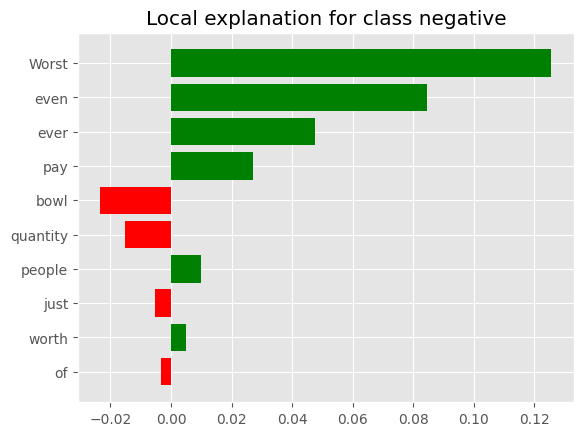

In [62]:
# Explanation of a negative review
explain_classification(tfidf, logistic, train.iloc[46,0])

Original text:
Great ambience good food and best service by the staff members

Special mention for Desmond sir He is by far the best restaurant staff I have ever met Very courteous and cheerful person who really believes in great customer service

It was my first visit and we ordered
Jalapeno cheese bites recommended
Bacon wrapped prawns good
Murg malai tikka was ok but nothing great
Lal maas nice n spicy but had a lot of oil
Roomali roti good

Definitely looking forward to try out other items in their menu

Probability estimates [positive/negative]:
[[0.99769904 0.00230096]]

Probabilities:
[('best', -0.05240753818842268), ('courteous', -0.026978022135433016), ('Bacon', -0.02421143788717839), ('good', -0.020641914413861852), ('great', -0.0204802743882255), ('staff', 0.019434103835939406), ('nothing', 0.019211066297526034), ('mention', -0.017686817339754225), ('forward', -0.016934214125523622), ('nice', -0.01336402123129326)]



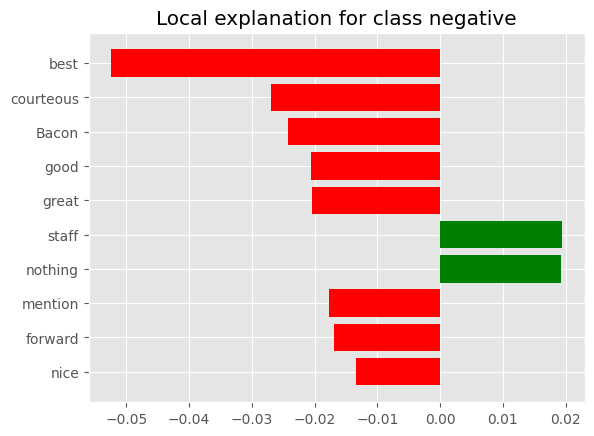

In [63]:
# Explanation of a positive review
explain_classification(tfidf, logistic, train.iloc[5,0])

# 6. Análisis de sentimiento con VADER

Finalmente vamos a usar VADER para obtener mayor información sobre los sentimientos en algunos reviews, obteniendo el grado de los sentimientos positivo, neutro y negativo que contiene.

Dado que VADER es sensible a puntuaciones usadas por énfasis, emoticones, y otros, no vamos a aplicar ninguna limpieza y vamos a aplicar directamente VADER sobre los datos, devolviendo 4 puntuaciones: negativo, neutro, positivo y compuesto.

In [64]:
data_vader = train[['review']].copy()
data_vader.head()

review
0  Ambience  35  Too noisy\nFood  3\nService  4\n...
1  If I could  I would rate it in negativeWorst s...
2                                    Hemanth reddyK 
3  Try out the filter coffee masala dosa idly and...
4  Decent Mutton Biryani Consistent I have tried ...

Calculamos los score de Vader sobre algunas reseñas individuales.

Scores compound mayores que cero se puede considerar reviews positivos, y menores que cero, negativos.

In [67]:
analyser = SentimentIntensityAnalyzer()

# Negative review
print(data_vader.iloc[46,0])
score = analyser.polarity_scores(data_vader.iloc[46,0])
print(score)

Worst decision ever They are just robbing people The quantity is so less And not even worth what
u pay for Food bowl is not even the length of spoon
{'neg': 0.21, 'neu': 0.79, 'pos': 0.0, 'compound': -0.7324}


In [68]:
# Positive review
print(data_vader.iloc[5,0])
score = analyser.polarity_scores(data_vader.iloc[5,0])
print(score)

Great ambience good food and best service by the staff members

Special mention for Desmond sir He is by far the best restaurant staff I have ever met Very courteous and cheerful person who really believes in great customer service

It was my first visit and we ordered
Jalapeno cheese bites recommended
Bacon wrapped prawns good
Murg malai tikka was ok but nothing great
Lal maas nice n spicy but had a lot of oil
Roomali roti good

Definitely looking forward to try out other items in their menu
{'neg': 0.039, 'neu': 0.653, 'pos': 0.308, 'compound': 0.9764}


Ahora vamos a agregar los Scores de Vader al dataset.

In [69]:
data_vader['scores'] = data_vader['review'].apply(lambda review: analyser.polarity_scores(review))

data_vader.head()

review  \
0  Ambience  35  Too noisy\nFood  3\nService  4\n...   
1  If I could  I would rate it in negativeWorst s...   
2                                    Hemanth reddyK    
3  Try out the filter coffee masala dosa idly and...   
4  Decent Mutton Biryani Consistent I have tried ...   

                                              scores  
0  {'neg': 0.089, 'neu': 0.809, 'pos': 0.102, 'co...  
1  {'neg': 0.143, 'neu': 0.771, 'pos': 0.086, 'co...  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3  {'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...  
4  {'neg': 0.109, 'neu': 0.71, 'pos': 0.181, 'com...

Ahora vamos a agregar compound como una columna separada:

In [70]:
data_vader['compound']  = data_vader['scores'].apply(lambda score_dict: score_dict['compound'])

data_vader.head()

review  \
0  Ambience  35  Too noisy\nFood  3\nService  4\n...   
1  If I could  I would rate it in negativeWorst s...   
2                                    Hemanth reddyK    
3  Try out the filter coffee masala dosa idly and...   
4  Decent Mutton Biryani Consistent I have tried ...   

                                              scores  compound  
0  {'neg': 0.089, 'neu': 0.809, 'pos': 0.102, 'co...    0.3612  
1  {'neg': 0.143, 'neu': 0.771, 'pos': 0.086, 'co...   -0.7561  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
3  {'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...    0.9324  
4  {'neg': 0.109, 'neu': 0.71, 'pos': 0.181, 'com...    0.2975

Todos los valores mayores a cero serían considerados reviews positivos, y los menores que cero, serían considerados como reviews negativos.

Así construimos la variable "bad" del dataset original con la clasificación correspondiente.

In [71]:
data_vader['bad'] = data_vader['compound'].apply(lambda c: 0 if c >=0 else 1)

data_vader.head()

review  \
0  Ambience  35  Too noisy\nFood  3\nService  4\n...   
1  If I could  I would rate it in negativeWorst s...   
2                                    Hemanth reddyK    
3  Try out the filter coffee masala dosa idly and...   
4  Decent Mutton Biryani Consistent I have tried ...   

                                              scores  compound  bad  
0  {'neg': 0.089, 'neu': 0.809, 'pos': 0.102, 'co...    0.3612    0  
1  {'neg': 0.143, 'neu': 0.771, 'pos': 0.086, 'co...   -0.7561    1  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000    0  
3  {'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'comp...    0.9324    0  
4  {'neg': 0.109, 'neu': 0.71, 'pos': 0.181, 'com...    0.2975    0